In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

import nltk
import unidecode
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder


In [2]:
data= pd.read_csv("Tweets.csv",encoding = 'ISO-8859-1')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
print("Percentage null or na values in df")
((data.isnull() | data.isna()).sum() * 100 / data.index.size).round(2)

Percentage null or na values in df


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

In [4]:
del data['tweet_coord']
del data['airline_sentiment_gold']
del data['negativereason_gold']

In [5]:
#Removing Twitter Handles
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

# remove twitter handles (@...)
data['tidy_text'] = np.vectorize(remove_pattern)(data['text'], "@[\w]*")

# remove special characters, numbers, punctuations
data['tidy_text'] = data['tidy_text'].str.replace("[^a-zA-Z#]", " ")

#Remove greek or unknown characters if any
data['tidy_text'] = data['tidy_text'].apply(lambda x : ' '.join([unidecode.unidecode(word) for word in x.split()]))

#replace with obvious words
d = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
               'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
               'cud':'could','fud':'food','ve':'have', 'didn':'did not'} ## Need a huge dictionary
data['tidy_text'] = data['tidy_text'].apply(lambda x : ' '.join(d[word] if word in d else word for word in x.split()))

#Removing stop words like a, an, the etc
data['tidy_text'] = data['tidy_text'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stopwords.words('english'))]))

#Stemming and Lemmatizing
lemmatizer = WordNetLemmatizer()
data['tidy_text'] = data['tidy_text'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
ps = PorterStemmer()
data['tidy_text'] = data['tidy_text'].apply(lambda x : ' '.join([ps.stem(word) for word in x.split()]))

#Tokenization
corpus = []
for i in range(0,14640):
    tweet = data['tidy_text'][i]
    tweet = tweet.lower()
    tweet = tweet.split()
    tweet = [word for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus.append(tweet)
    
data[['text','tidy_text']].head()

,text,tidy_text
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you've added commercials t...,plu ad commerci experi tacki
2,@VirginAmerica I didn't today... Must mean I n...,I today must mean I need take anoth trip
3,@VirginAmerica it's really aggressive to blast...,realli aggress blast obnoxi entertain guest fa...
4,@VirginAmerica and it's a really big bad thing...,realli big bad thing


In [6]:

sentiment = []
for i in range(0,len(data['airline_sentiment'])): 
    if data['airline_sentiment'][i]=='negative':
        sentiment.append(0)
    if data['airline_sentiment'][i]=='positive':
        sentiment.append(1)
    if data['airline_sentiment'][i]=='neutral':
        sentiment.append(2)

data['sentiment'] = sentiment
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,tidy_text,sentiment
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),what said,2
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plu ad commerci experi tacki,1
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I today must mean I need take anoth trip,2
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),realli aggress blast obnoxi entertain guest fa...,0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),realli big bad thing,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,KristenReenders,0,@AmericanAir thank you we got on a different f...,2015-02-22 12:01:01 -0800,NaN,NaN,thank got differ flight chicago,1
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flig...,2015-02-22 11:59:46 -0800,Texas,NaN,leav minut late flight No warn commun minut la...,0
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,sanyabun,0,@AmericanAir Please bring American Airlines to...,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN,pleas bring american airlin #blackberri,2
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,SraJackson,0,"@AmericanAir you have my money, you change my ...",2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada),money chang flight answer phone ani suggest I ...,0


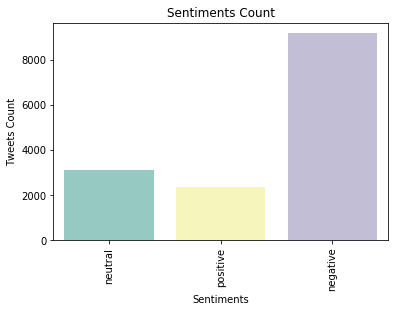

In [7]:
sns.countplot(x=data['airline_sentiment'], palette="Set3")
plt.xticks(rotation =90)
plt.xlabel('Sentiments')
plt.ylabel('Tweets Count')
plt.title('Sentiments Count')
plt.show()

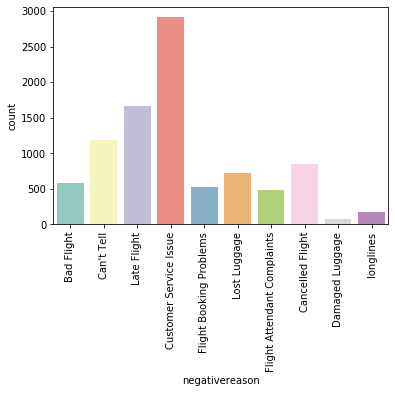

In [8]:

# Count of reasons for negative tweets for airlines, overall customer service issue was major problem
sns.countplot(x=data['negativereason'], palette="Set3")
plt.xticks(rotation =90)
plt.show()

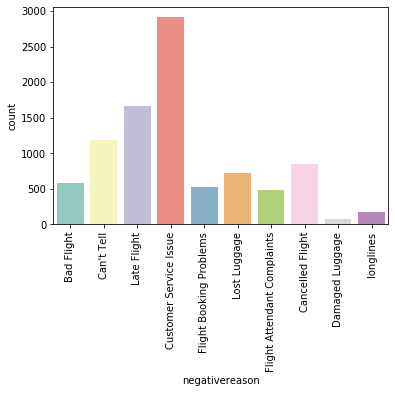

In [9]:

# Count of reasons for negative tweets for airlines, overall customer service issue was major problem
sns.countplot(x=data['negativereason'], palette="Set3")
plt.xticks(rotation =90)
plt.show()

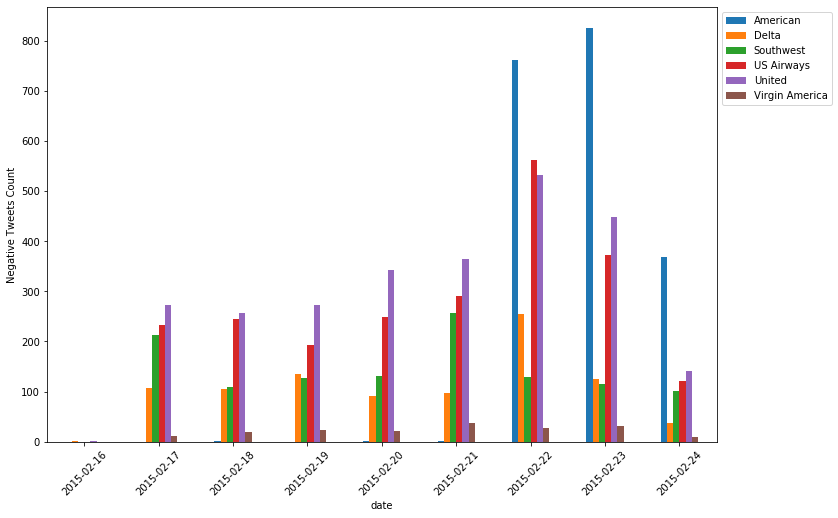

In [10]:
# Converting datetime column to pandas datetime format and keeping only date
data['date'] = pd.to_datetime(data['tweet_created'])
data['date'] = data['date'].apply(lambda x : x.date())

df1 = data.groupby(['date','airline','airline_sentiment']).size()
df1 = df1.loc(axis=0)[:,:,'negative']
axis = df1.groupby(['date', 'airline']).sum().unstack().plot(kind='bar', figsize=(12,8), rot=45)
axis.set_ylabel('Negative Tweets Count')
axis.legend(loc='upper left', bbox_to_anchor = (1,1))

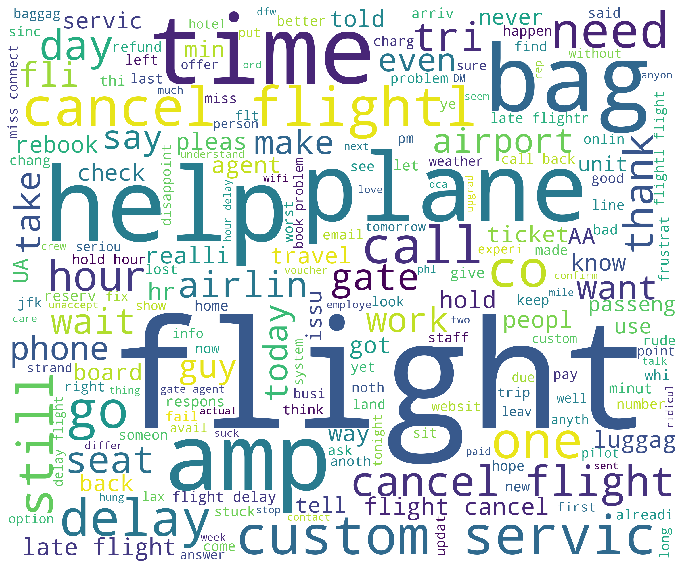

In [11]:
new_df=data[data['airline_sentiment']=='negative']
words = ' '.join(new_df['tidy_text'])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(words)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [12]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer  
cv = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')  
X = cv.fit_transform(corpus).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [13]:
sentiment = []
for i in range(0,len(data['airline_sentiment'])): 
    if data['airline_sentiment'][i]=='negative':
        sentiment.append(0)
    if data['airline_sentiment'][i]=='positive':
        sentiment.append(2)
    if data['airline_sentiment'][i]=='neutral':
        sentiment.append(1)
data['sentiment'] = sentiment
Y = data['sentiment'].values
Y

array([1, 2, 1, ..., 1, 0, 1], dtype=int64)

In [22]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

# KNN

In [15]:
# try K=1 through K=15 and record testing accuracy
k_range = list(range(1, 16))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(Y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

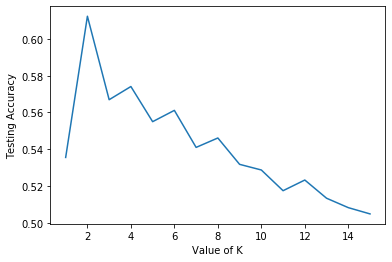

In [16]:
plt.plot(k_range, scores)
plt.xlabel('Value of K')
plt.ylabel('Testing Accuracy')

In [17]:
#With k = 2
kn = KNeighborsClassifier(n_neighbors=2)
model_knn = kn.fit(X_train,Y_train)
k_pred = model_knn.predict(X_test)
print(metrics.accuracy_score(Y_test,k_pred))

0.612363387978142


In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,k_pred)
print(cm)

[[1310  522   38]
 [ 259  326   29]
 [ 152  135  157]]


# Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
X3_train, X3_test, Y3_train, Y3_test = train_test_split(data['tidy_text'],data['sentiment'], test_size = 0.2, random_state=0, shuffle = True, stratify=data['sentiment'])

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report
#Training and testing the randomforest model
rf = Pipeline([('tfidf', TfidfVectorizer()), ('rf', LogisticRegression())])
rf.fit(X3_train, Y3_train)
y_pred = rf.predict(X3_test)
print(pd.crosstab(Y3_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(Y3_test, y_pred))

C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Predicted     0    1    2
Actual                   
0          1752   62   22
1           330  252   38
2           152   57  263
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1836
           1       0.68      0.41      0.51       620
           2       0.81      0.56      0.66       472

    accuracy                           0.77      2928
   macro avg       0.76      0.64      0.68      2928
weighted avg       0.77      0.77      0.75      2928



In [23]:
#Logistic Regression using 10 fold - cross validation
lr = LogisticRegression()
scores = cross_val_score(lr, X, Y, cv=10, scoring='accuracy')
print(scores)
s0 = scores.mean()

#Logistic Regression using 5 fold - cross validation

lr = LogisticRegression()
scores = cross_val_score(lr, X, Y, cv=5, scoring='accuracy')
print(scores)
s1 = scores.mean()

#Logistic Regression using 15 fold - cross validation

lr = LogisticRegression()
scores = cross_val_score(lr, X, Y, cv=15, scoring='accuracy')
print(scores)
s2 = scores.mean()

#Logistic Regression using 20 fold - cross validation

lr = LogisticRegression()
scores = cross_val_score(lr, X, Y, cv=20, scoring='accuracy')
print(scores)
s3 = scores.mean()

#Taking the average of 4 cross validated accuracies
print('Average accuracy of Logistic Regression is '+ str((s0 + s1 + s2 + s3)/4))

C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

[0.76791809 0.75153584 0.75358362 0.7807377  0.75614754 0.74521858
 0.80396175 0.76775956 0.76760082 0.78659371]


C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

[0.75520656 0.75998634 0.7791055  0.78066279 0.77922078]


C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

[0.76356192 0.76765609 0.75742068 0.7430911  0.75844422 0.78607984
 0.73797339 0.79324463 0.81147541 0.8174359  0.78871795 0.75794872
 0.76615385 0.78234086 0.78336756]


C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[0.7680764  0.76944065 0.74488404 0.76502732 0.76092896 0.74180328
 0.76092896 0.78825137 0.73497268 0.78551913 0.78688525 0.81693989
 0.82786885 0.79781421 0.7773224  0.75409836 0.76229508 0.78005464
 0.80574555 0.77123288]
Average accuracy of Logistic Regression is 0.7720685206328776


# Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

#1 - RandomForest classification with Pipeline
X2_train, X2_test, Y2_train, Y2_test = train_test_split(data['tidy_text'],data['sentiment'], test_size = 0.2, random_state=0, shuffle = True, stratify=data['sentiment'])


#Training and testing the randomforest model
rf = Pipeline([('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])
rf.fit(X2_train, Y2_train)
y_pred = rf.predict(X2_test)
print(pd.crosstab(Y2_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(Y2_test, y_pred))

C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Predicted     0    1    2
Actual                   
0          1672  103   61
1           316  246   58
2           154   57  261
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1836
           1       0.61      0.40      0.48       620
           2       0.69      0.55      0.61       472

    accuracy                           0.74      2928
   macro avg       0.69      0.62      0.64      2928
weighted avg       0.73      0.74      0.73      2928



In [ ]:
#Random Forest using 5 fold Cross validation with 
rf = RandomForestClassifier()
scores = cross_val_score(rf, X, Y, cv=5, scoring='accuracy')
print(scores)
s0 = scores.mean()

#Random Forest using 10 fold Cross validation with 
rf = RandomForestClassifier()
scores = cross_val_score(rf, X, Y, cv=10, scoring='accuracy')
print(scores)
s1 = scores.mean()

#Random Forest using 15 fold Cross validation with 
rf = RandomForestClassifier()
scores = cross_val_score(rf, X, Y, cv=15, scoring='accuracy')
print(scores)
s2 = scores.mean()

#Random Forest using 15 fold Cross validation with 
rf = RandomForestClassifier()
scores = cross_val_score(rf, X, Y, cv=20, scoring='accuracy')
print(scores)
s3 = scores.mean()

print('Average accuracy of Random Forest is '+ str((s0 + s1 + s2 + s3)/4))

C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarni

[0.71662684 0.70945715 0.70536019 0.73727366 0.73274094]


C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarni

[0.71945392 0.71808874 0.71535836 0.72472678 0.70696721 0.69945355
 0.76229508 0.73224044 0.72932331 0.74213406]


C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarni

[0.72773797 0.72364381 0.71954964 0.70214944 0.71545548 0.71750256
 0.67041965 0.74002047 0.76639344 0.76512821 0.75179487 0.71282051
 0.72923077 0.75975359 0.74640657]


C:\Users\dcL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
